# Food 101 - Fellowship.ai challenge

## Food 101 - fellowship challenge summary
Food-101 is a challenging vision problem, but everyone can relate to it.  Recent SoTA is ~80% top-1, 90% top-5.  These approaches rely on lots of TTA, large networks and  even novel architectures.

Train a decent model >85% accuracy for top-1 for the test set, using a ResNet50 or smaller network with a reasonable set of augmentations.

Recognizing food is a challenging problem for computer vision. The same dish can appear very differently on image, due to several factors like variation in recipe, lighting, spatial layout. At the same time, different dishes can look very much alike due to their similar color, texture, ingredients.  

## Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [ ]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [ ]:
doc(untar_data)

In [ ]:
url="http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"
!wget {url}
#path = download_url(url,'/content/data/'); path
#/content/data/food-101.tar.gz.tgz

--2020-02-06 09:24:43--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2020-02-06 09:24:43--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  19.6MB/s    in 4m 31s  

2020-02-06 09:29:14 (17.6 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



In [ ]:
! cp '/content/drive/My Drive/Colab Notebooks/food-101.tar.gz' /content/

In [ ]:
#!cd /content/data
!tar xzf '/content/drive/My Drive/Colab Notebooks/food-101.tar.gz'

In [ ]:
! head /content/food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [ ]:
!sed 's/$/.jpg/' /content/food-101/meta/train.txt > /content/food-101/meta/train-fullname.txt

In [ ]:
!rsync --files-from='/content/food-101/meta/train-fullname.txt' /content/food-101/images /content/data/train --remove-source-files

In [ ]:
!sed 's/$/.jpg/' /content/food-101/meta/test.txt > /content/food-101/meta/test-fullname.txt

In [ ]:
!rsync --files-from='/content/food-101/meta/test-fullname.txt' /content/food-101/images /content/data/test --remove-source-files

In [ ]:
#!mkdir /content/data/images

In [ ]:
#!cp -ar /content/food-101/images/c* /content/data/images/

In [ ]:
#!find /content/data/images/ -type f -name '*[02468].jpg' -exec rm -f {} +

In [ ]:
!find /content/data/test/ -type f | wc -l

25250


In [ ]:
#import tarfile
#tar = tarfile.open('/content/data/food-101.tar.gz', "r:gz")
#tar.extractall()
#tar.close()

In [ ]:
path=Path('/content/data/')
path.ls()

[PosixPath('/content/data/test'),
 PosixPath('/content/data/toploss'),
 PosixPath('/content/data/train')]

In [ ]:
#path_anno = path/'annotations'
path_train = path/'train'; path_train
path_test=path/'test'; path_test

PosixPath('/content/data/test')

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

[]

In [ ]:
np.random.seed(23)


In [ ]:
doc(ImageDataBunch.from_folder)

In [ ]:
data = ImageDataBunch.from_folder(path_img, valid_pct=0.2, ds_tfms=get_transforms(max_lighting=0.2), size=224, bs=bs).normalize(imagenet_stats)

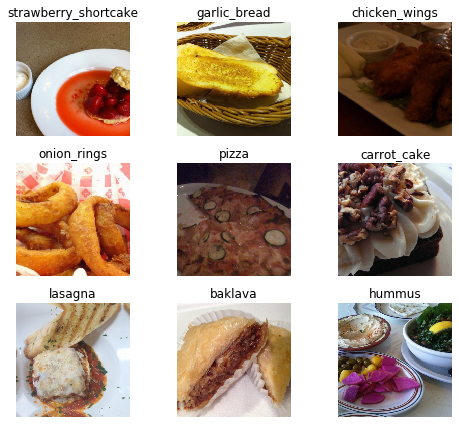

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

In [ ]:
print(data.classes)
len(data.classes),data.c

NameError: ignored

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.model

In [ ]:
learn.fit_one_cycle(6,max_lr=1e-4)

KeyboardInterrupt: ignored

In [ ]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

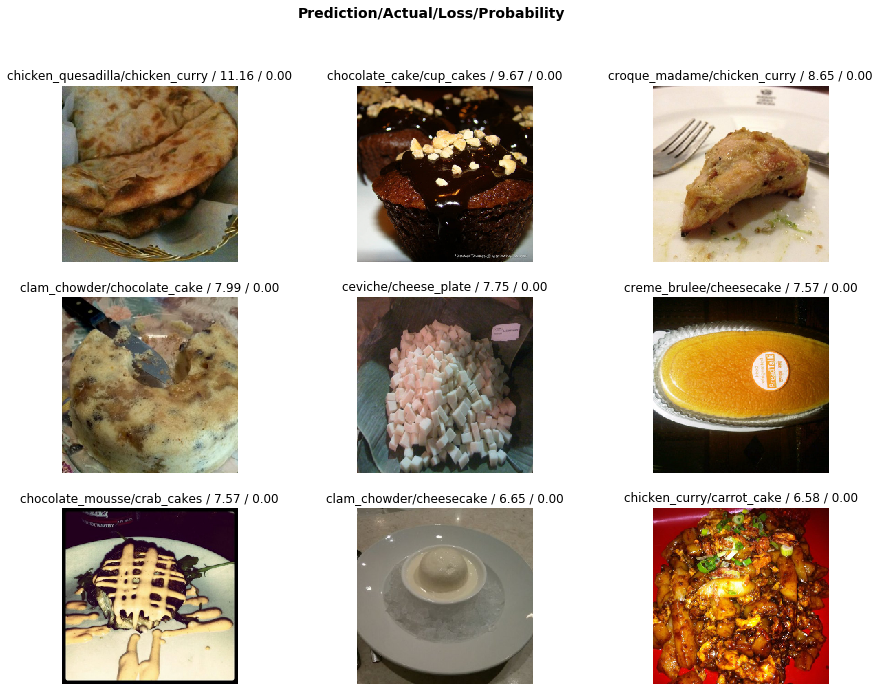

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
doc(interp.plot_top_losses)

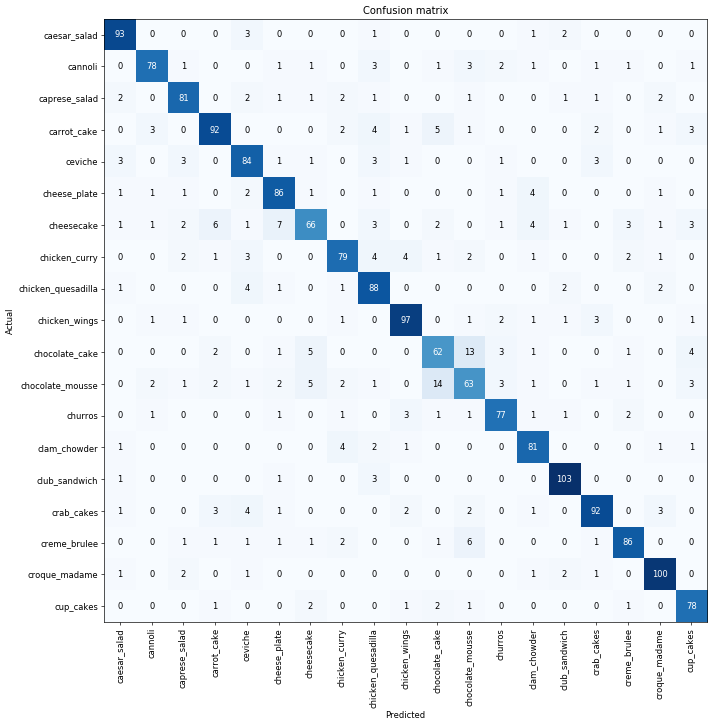

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=3)

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)

In [ ]:
learn.load('stage-1');

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


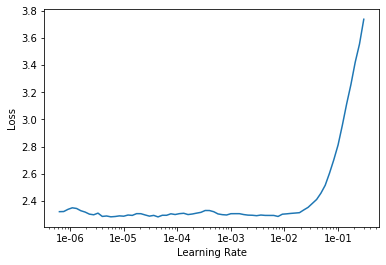

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [ ]:
data = ImageDataBunch.from_folder(path_img, valid_pct=0.2, ds_tfms=get_transforms(),
                                   size=224, bs=bs).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

NameError: ignored

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


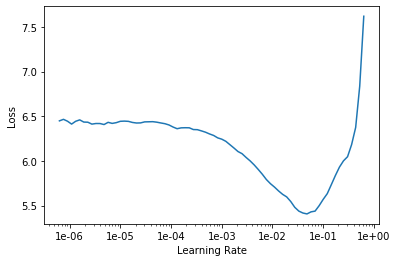

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(6,max_lr=slice(1e-4,1e-2))

In [ ]:
learn.save('R50_224')
learn.save('/content/drive/My Drive/Colab Notebooks/R50_224')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(3e-4,4e-3))

In [ ]:
learn.fit_one_cycle(8, max_lr=slice(1e-4,1e-2))

In [ ]:
learn.fit_one_cycle(8, max_lr=slice(5e-5,5e-3))

In [ ]:
!cp '/content/models/stage-1-50.pth' '/content/drive/My Drive/Colab Notebooks/'

In [ ]:
!cp '/content/data/food-101.tar.gz' '/content/drive/My Drive/Colab Notebooks/'

If it doesn't, you can always go back to your previous model.

In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=3)

In [ ]:
data = ImageDataBunch.from_folder(path_img, valid_pct=0.25, ds_tfms=get_transforms(),
                                   size=64, bs=bs*2).normalize(imagenet_stats)

In [ ]:
learn50 = cnn_learner(data, models.resnet50, metrics=error_rate)

In [ ]:
learn50.fit_one_cycle(4,max_lr=slice(1e-3,1e-2))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


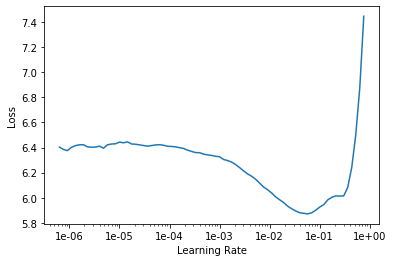

In [ ]:
learn50.lr_find()
learn50.recorder.plot()

In [ ]:
learn50.unfreeze()

In [ ]:
learn50.fit_one_cycle(3,max_lr=slice(1e-4,1e-2))

In [ ]:
learn50.save('R50_64')
learn50.save('/content/drive/My Drive/Colab Notebooks/R50_64')

In [ ]:
# data = ImageDataBunch.from_folder(path=path, train='train', test='test', valid_pct=0.25, ds_tfms=None, size=256, bs=64).normalize(imagenet_stats)
def get_data(sz, bs):
  data = ImageDataBunch.from_folder(path=path, train='train', valid_pct=0.25, ds_tfms=get_transforms(max_lighting=0.2), size=sz, bs=bs).normalize(imagenet_stats)
  return data

In [ ]:
def make_model(sz):
  learn50 = cnn_learner(get_data(sz, 8192//sz), models.resnet50, metrics=[error_rate, accuracy]).load('R50_'+str(sz//2))
  print('Made model learn50')

def find_lr():
  learn50.lr_find()
  learn50.recorder.plot()

def train_freeze(l1,l2):
  learn50.fit_one_cycle(2,max_lr=slice(l1,l2))

def train_unfreeze(sz,l1,l2):
  learn50.unfreeze()
  learn50.fit_one_cycle(2,max_lr=slice(l1,l2))
  learn50.save('R50_'+str(sz))
  learn50.save('/content/drive/My Drive/Colab Notebooks/R50_'+str(sz))
  print('saved weights R50_'+str(sz))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


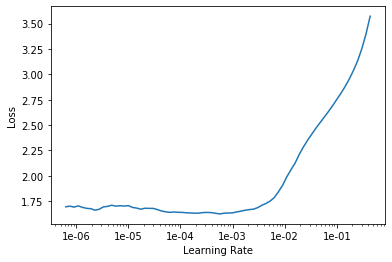

In [ ]:
sz=128
make_model(sz)
find_lr()

In [ ]:
l1=1e-5; l2=1e-3
train_freeze(l1,l2)

In [ ]:
train_unfreeze(sz,l1,l2)

Made model learn50


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


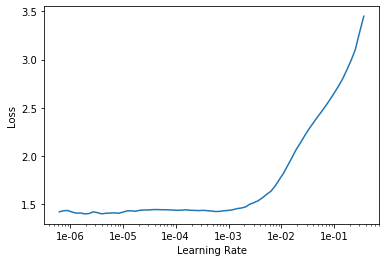

In [ ]:
sz=256
make_model(sz)
find_lr()

In [ ]:
l1=1e-6; l2=1e-4
train_freeze(l1,l2)

In [ ]:
train_unfreeze(sz,l1,l2)

saved weights R50_256


In [ ]:
learn50.load('R50_256')
train_unfreeze(sz,l1,l2)

saved weights R50_256


Made model learn50


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


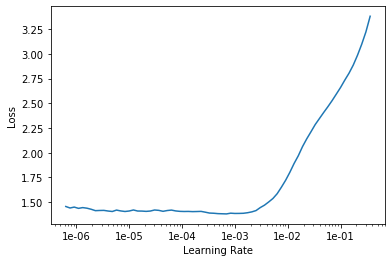

In [ ]:
sz=512
make_model(sz)
find_lr()

In [ ]:
l1=5e-6; l2=5e-4
train_freeze(l1,l2)

In [ ]:
train_unfreeze(sz,l1,l2)

saved weights R50_512


=================

In [ ]:
!cp '/content/drive/My Drive/Colab Notebooks/R50_256.pth' '/content/models'

In [ ]:
l1=1e-6;l2=1e-4
def train_model(sz):
  prev='256' if sz==256 else str(sz//2)
  learn50 = cnn_learner(get_data(sz, 64), models.resnet50, metrics=[error_rate, accuracy]).load('/content/models/R50_'+prev)
  learn50.fit_one_cycle(6,max_lr=slice(l1,l2))
  learn50.unfreeze()
  learn50.fit_one_cycle(4,max_lr=slice(l1,l2))
  learn50.save('/content/models/R50_'+str(sz)+'_cln')
  learn50.save('/content/drive/My Drive/Colab Notebooks/R50_'+str(sz)+'_cln')
  print('saved weights R50_'+str(sz)+'_cln')
  return learn50

In [ ]:
for i in [128,256,512]:
  train_model(i)

saved weights R50_128


saved weights R50_256


KeyboardInterrupt: ignored

In [ ]:
train_model(256)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


saved weights R50_256


In [ ]:
train_model(256)

saved weights R50_256


In [ ]:
!cd /root/.cache/torch/checkpoints && curl -O https://download.pytorch.org/models/resnet50-19c8e357.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 97.7M  100 97.7M    0     0  70.0M      0  0:00:01  0:00:01 --:--:-- 70.0M


In [ ]:
interp = ClassificationInterpretation.from_learner(learn50n)

losses,idxs = interp.top_losses()

#len(data.valid_ds)==len(losses)==len(idxs)


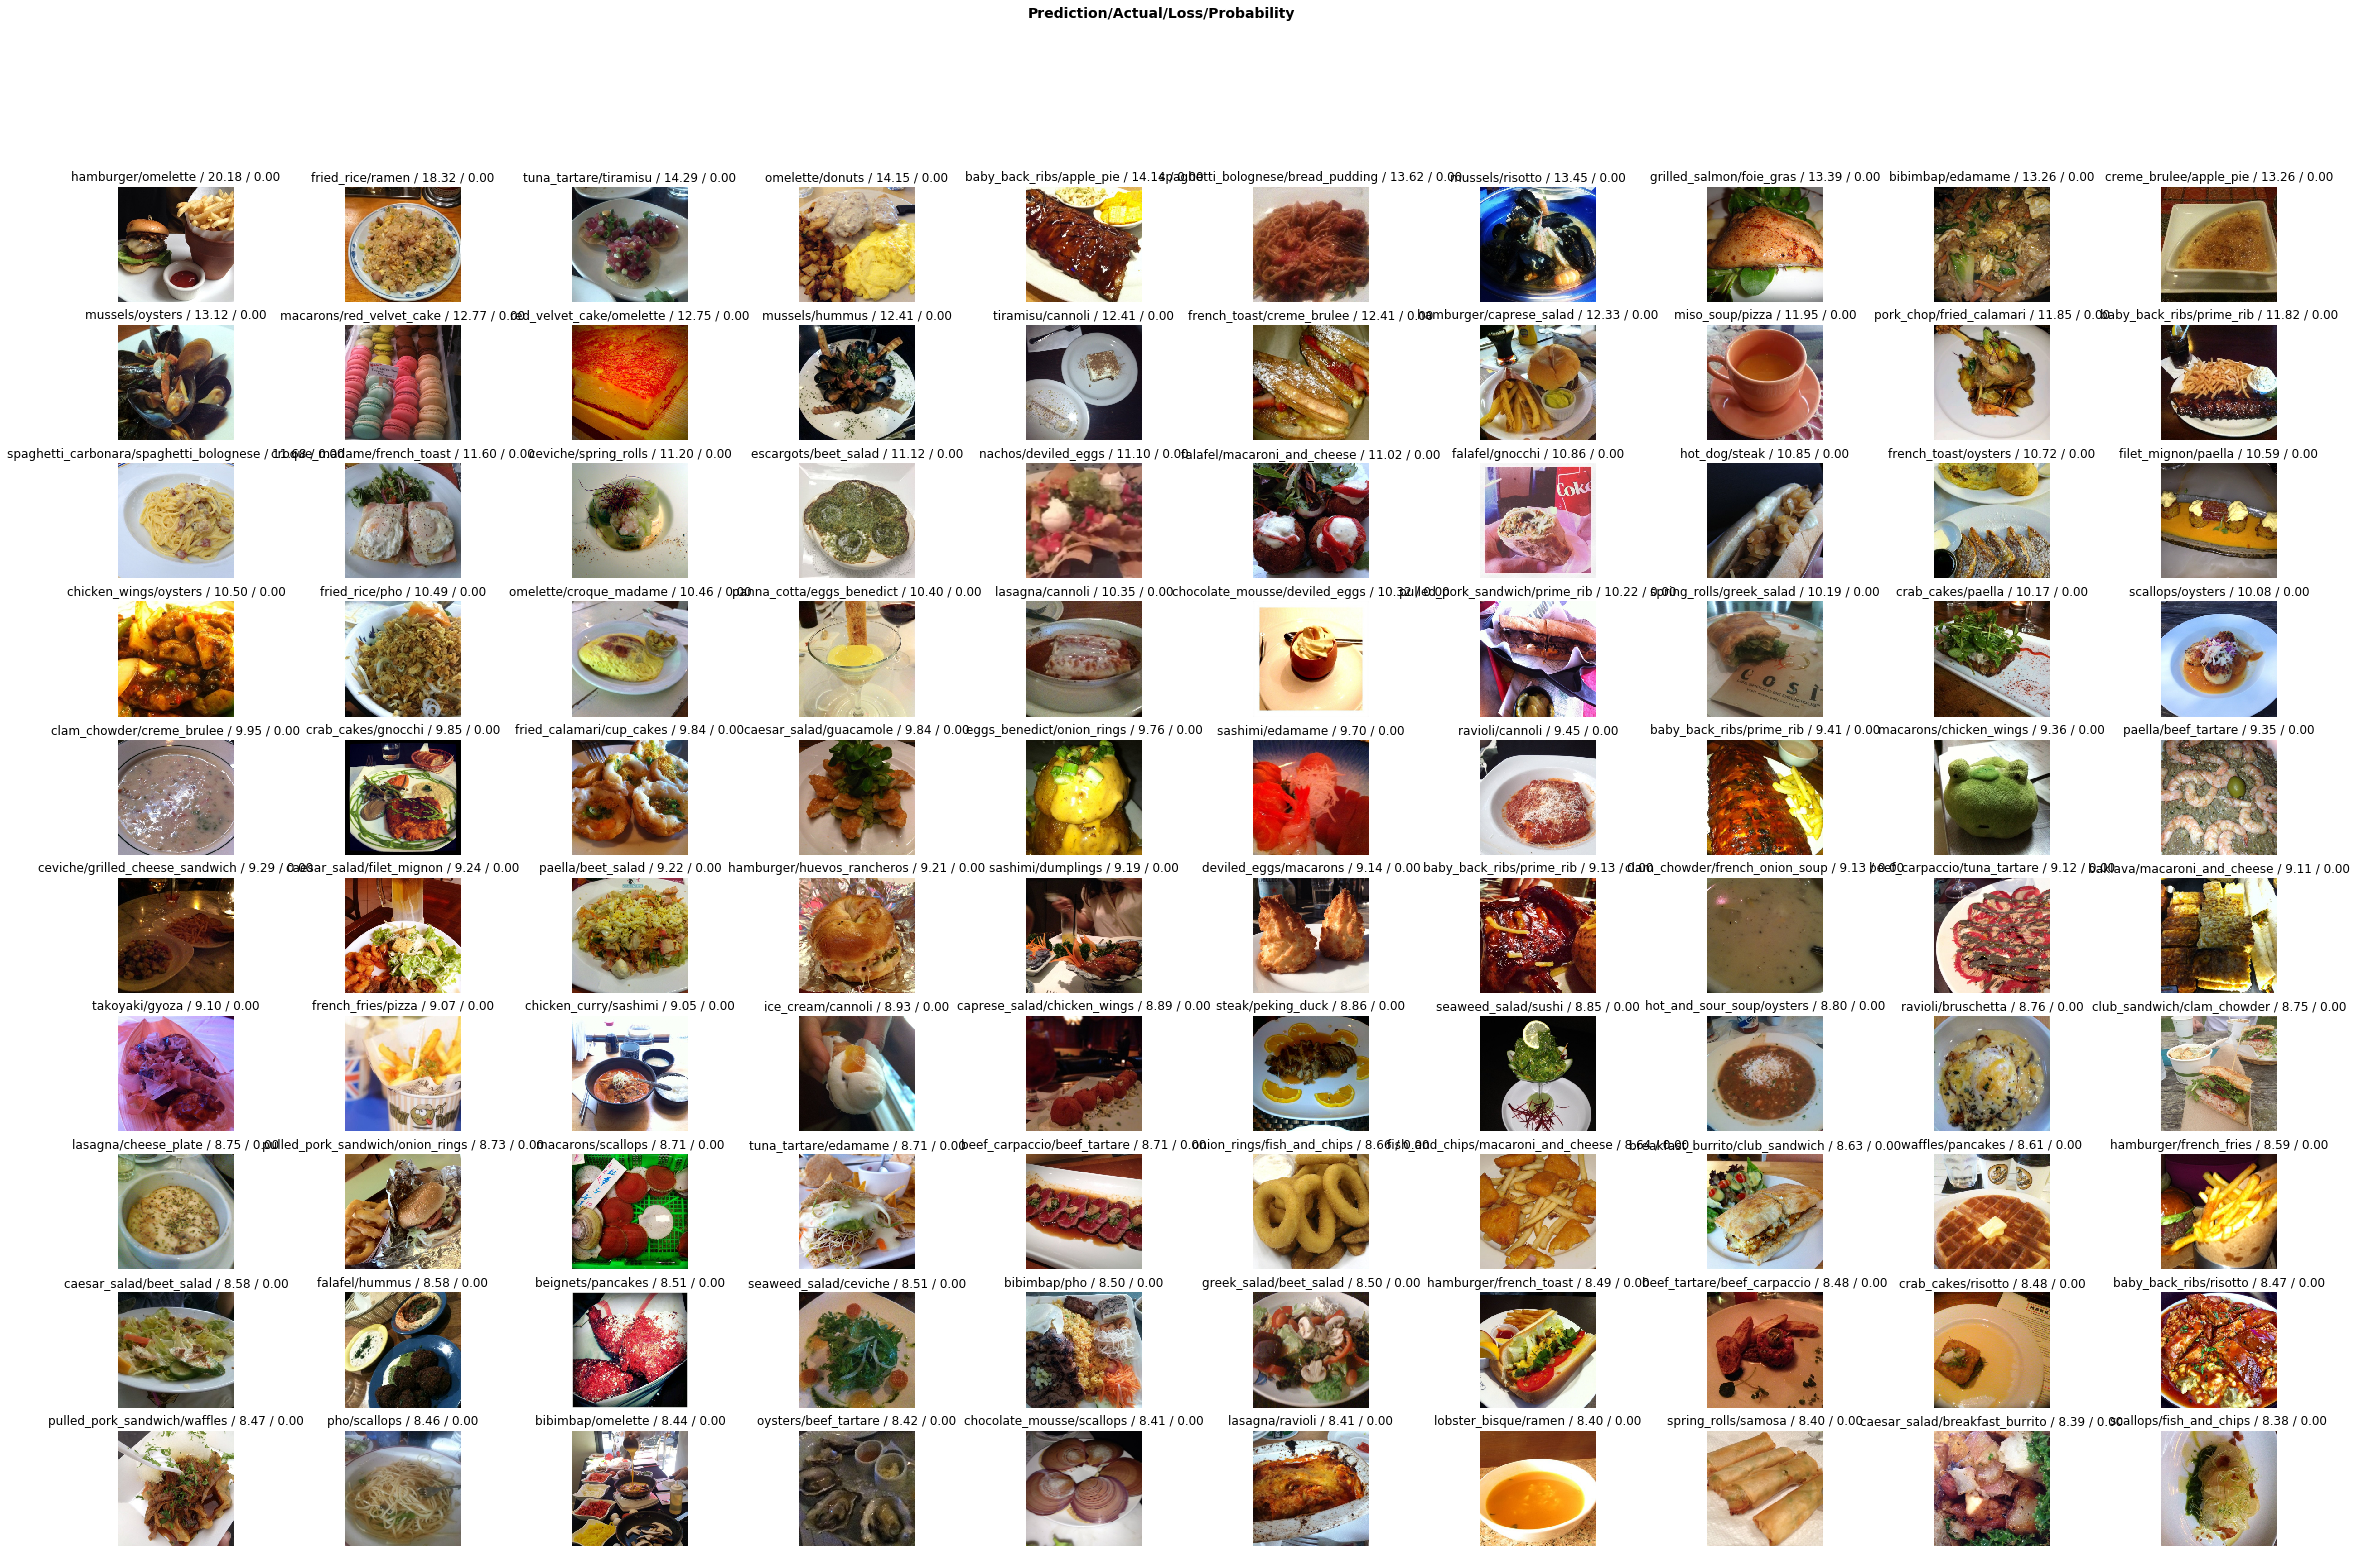

In [ ]:
interp.plot_top_losses(100, figsize=(40,25))

In [ ]:
len(idxs)
# interp.data.valid_ds.x.items[idxs[0]]

74992

In [ ]:
mislabidx=list(range(0,1000))
# for i in [39,47,64,78,85,88]: 
#   mislabeled.remove(i)
# print(mislabeled)
len(mislabidx)

1000

In [ ]:
losses[1000]

tensor(4.3099)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

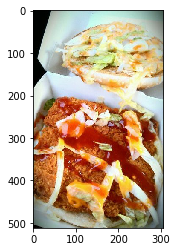

In [ ]:
# img = mpimg.imread(interp.data.valid_ds.x.items[idxs[88]])
img = mpimg.imread('/content/data/946518.jpg')
imgplot = plt.imshow(img)

In [ ]:
sz=256; bs=64
data = ImageDataBunch.from_folder(path=path_train, train='train',  valid_pct=0.99, ds_tfms=get_transforms(max_lighting=0.2), size=sz, bs=bs).normalize(imagenet_stats)
learn50n = cnn_learner(data, models.resnet50, metrics=[error_rate, accuracy]).load('/content/models/R50_256')

In [ ]:
learn50.metrics

[<function fastai.metrics.error_rate>, <function fastai.metrics.accuracy>]

In [ ]:
learn50.validate(learn50.data.valid_dl)

[0.34337917, tensor(0.0951), tensor(0.9049)]

In [ ]:
learn50n.validate(learn50n.data.valid_dl)

[0.38234022, tensor(0.1041), tensor(0.8959)]

In [ ]:
learn50.validate(learn50.data.train_dl)

[0.39212483, tensor(0.1075), tensor(0.8925)]

In [ ]:
learn50n.validate(learn50n.data.train_dl)

[0.4362537, tensor(0.1196), tensor(0.8804)]

In [ ]:
learn50.validate(learn50.data.test_dl) #Incorrect Test-dl code, wrong result

[13.816949, tensor(0.9905), tensor(0.0095)]

In [ ]:
learn50.validate(learn50.data.valid_dl) #Correct Test: passed test data in valid dl by changing 'data'

[0.5320432, tensor(0.1481), tensor(0.8519)]

In [ ]:
learn50n.validate(learn50n.data.valid_dl)

[0.5320432, tensor(0.1481), tensor(0.8519)]

In [ ]:
mislabimgs=[]
for i in mislabidx:
#   # !echo {interp.data.valid_ds.x.items[idxs[i]]}
#   # !mv {interp.data.valid_ds.x.items[idxs[i]]} /content/data/
  mislabimgs.append(str(interp.data.valid_ds.x.items[idxs[i]])[20:]+'\n')
# str(interp.data.valid_ds.x.items[idxs[0]])
with open('/content/models/mislabimgs.txt', 'w') as f:
  f.writelines(mislabimgs)

!cp '/content/models/mislabimgs.txt' '/content/drive/My Drive/Colab Notebooks/'

In [ ]:
# with open('/content/models/mislabimgs.txt', 'w') as f:
#   f.writelines(mislabimgs)
!cp '/content/models/mislabimgs.txt' '/content/drive/My Drive/Colab Notebooks/'

In [ ]:
!head /content/models/mislabimgs.txt

omelette/1186923.jpg
ramen/284037.jpg
tiramisu/1615311.jpg
donuts/3269758.jpg
apple_pie/1158360.jpg
bread_pudding/325137.jpg
risotto/2182823.jpg
foie_gras/250733.jpg
edamame/1734785.jpg
apple_pie/330431.jpg


In [ ]:
!rsync --files-from='/content/models/mislabimgs.txt' /content/data/train/ /content/data/toploss --remove-source-files

In [ ]:
sz=256; bs=64
data = ImageDataBunch.from_folder(path=path_train, train='train',  valid_pct=0.25, ds_tfms=get_transforms(max_lighting=0.2), size=sz, bs=bs).normalize(imagenet_stats)
learn50cln = cnn_learner(data, models.resnet50, metrics=[error_rate, accuracy]).load('/content/models/R50_256')

In [ ]:
l1=1e-5; l2=1e-3
learn50cln.fit_one_cycle(6,max_lr=l2)
# learn50cln.unfreeze()
# learn50cln.fit_one_cycle(4,max_lr=slice(l1,l2))
# learn50cln.save('/content/models/R50_'+str(sz)+'_cln')
# learn50cln.save('/content/drive/My Drive/Colab Notebooks/R50_'+str(sz)+'_cln')
# print('saved weights R50_'+str(sz)+'_cln')

KeyboardInterrupt: ignored

In [ ]:
l1=1e-5; l2=1e-3
learn50cln.fit_one_cycle(4,max_lr=l2)
learn50cln.unfreeze()
learn50cln.fit_one_cycle(4,max_lr=slice(l1,l2))
learn50cln.save('/content/models/R50_'+str(sz)+'_cln')
learn50cln.save('/content/drive/My Drive/Colab Notebooks/R50_'+str(sz)+'_cln')
print('saved weights R50_'+str(sz)+'_cln')

In [ ]:
train_model(256)

KeyboardInterrupt: ignored

In [ ]:
learn50n.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [ ]:
l1=1e-5;l2=1e-4
learn50cln=train_model(256)

KeyboardInterrupt: ignored

In [ ]:
learn50cln = cnn_learner(get_data(sz, 64), models.resnet50, metrics=[error_rate, accuracy]).load('/content/models/R50_256')
learn50cln.unfreeze()
learn50cln.fit_one_cycle(4,max_lr=slice(l1,l2))
learn50cln.save('/content/models/R50_'+str(sz)+'_cln')
learn50cln.save('/content/drive/My Drive/Colab Notebooks/R50_'+str(sz)+'_cln')
print('saved weights R50_'+str(sz)+'_cln')

saved weights R50_256_cln


In [ ]:
learn50cln.lr_find()
learn50cln.recorder.plot()

RuntimeError: ignored

In [ ]:
l1=1e-5;l2=1e-4
# learn50cln = cnn_learner(get_data(sz, 64), models.resnet50, metrics=[error_rate, accuracy]).load('/content/models/R50_256')
learn50cln.fit_one_cycle(4,max_lr=slice(l1,l2))
l1=3e-6;l2=3e-5
learn50cln.unfreeze()
learn50cln.fit_one_cycle(4,max_lr=slice(l1,l2))
learn50cln.save('/content/models/R50_'+str(sz)+'_cln2')
learn50cln.save('/content/drive/My Drive/Colab Notebooks/R50_'+str(sz)+'_cln2')
print('saved weights R50_'+str(sz)+'_cln2')

In [ ]:
interp.most_confused(min_val=3)

## Other data formats

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample')

In [ ]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

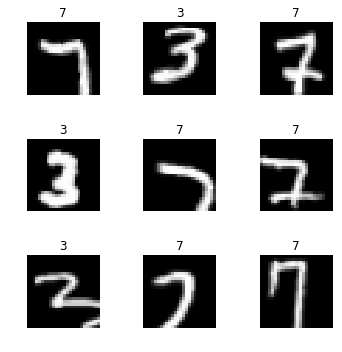

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      0.116117    0.029745    0.991168  (00:12)
2      0.056860    0.015974    0.994603  (00:10)



In [ ]:
df = pd.read_csv(path/'labels.csv')
df.head()

name  label
0   train/3/7463.png      0
1  train/3/21102.png      0
2  train/3/31559.png      0
3  train/3/46882.png      0
4  train/3/26209.png      0

In [ ]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

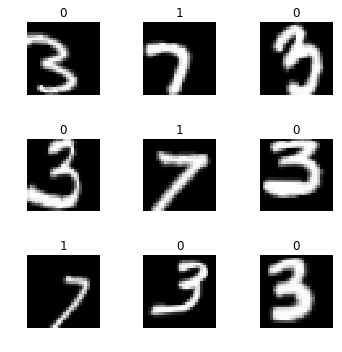

In [ ]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [ ]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [ ]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/21102.png')]

In [ ]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [ ]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [ ]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [ ]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']